# Experiment 01: Airline dataset

In this experiment we use [the airline dataset](http://kt.ijs.si/elena_ikonomovska/data.html) to predict arrival delay. The dataset consists of a large amount of records, containing flight arrival and departure details for all the commercial flights within the USA, from October 1987 to April 2008. Its size is around 116 million records and 5.76 GB of memory.



In [16]:
import os,sys
import numpy as np
import pandas as pd
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, precision_score,
                             recall_score)
from libs.loaders import load_airline
from libs.conversion import convert_cols_categorical_to_numeric, convert_related_cols_categorical_to_numeric
from libs.timer import Timer
import pkg_resources
import json
import matplotlib.pylab as plt

print("System version: {}".format(sys.version))
print("XGBoost version: {}".format(pkg_resources.get_distribution('xgboost').version))
print("LightGBM version: {}".format(pkg_resources.get_distribution('lightgbm').version))

%matplotlib inline

System version: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
XGBoost version: 0.6
LightGBM version: 0.2


/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# 1) XGBoost vs LightGBM benchmark
In the next section we compare both libraries speed, accuracy and other metrics for the dataset of airline arrival delay. 

### Data loading and management

In [2]:
%%time
df_plane = load_airline()
print(df_plane.shape)

MOUNT_POINT not found in environment. Defaulting to /fileshare
(115069017, 14)
CPU times: user 1min 10s, sys: 32.3 s, total: 1min 43s
Wall time: 3min 56s


In [3]:
df_plane.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,SFO,ORD,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,LAX,SFO,337,0,5
2,1987,10,1,4,5,35,HP,351,167,ICT,LAS,987,0,17
3,1987,10,1,4,5,40,DL,251,35,MCO,PBI,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,LAS,ORD,1515,0,17


The first step is to convert the categorical features to numeric features.

In [4]:
%%time
df_plane_numeric = convert_related_cols_categorical_to_numeric(df_plane, col_list=['Origin','Dest'])


CPU times: user 1min 33s, sys: 13.8 s, total: 1min 46s
Wall time: 1min 49s


In [5]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,HP,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,DL,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,4,33,1515,0,17


In [6]:
%%time
df_plane_numeric = convert_cols_categorical_to_numeric(df_plane_numeric, col_list='UniqueCarrier')


CPU times: user 52.7 s, sys: 10.2 s, total: 1min 2s
Wall time: 1min 4s


In [7]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17


To simplify the pipeline, we are going to set a classification problem where the goal is to classify wheather a flight has arrived delayed or not. For that we need to binarize the variable `ArrDelay`.

If you want to extend this experiment, you can set a regression problem and try to identify the number of minutes of delay a fight has. Both XGBoost and LightGBM have regression classes.

In [8]:
%%time
filter_func = lambda x: 1 if x > 0 else 0
df_plane_numeric['ArrDelayBinary'] = df_plane_numeric['ArrDelay'].map(filter_func)

CPU times: user 35.3 s, sys: 4.42 s, total: 39.7 s
Wall time: 40.4 s


In [9]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay,ArrDelayBinary
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27,1
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5,1
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17,1
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2,0
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17,1


Once the features are prepared, let's split the dataset into train, validation and test set.

In [10]:
def split_train_val_test_df(df, val_size=0.2, test_size=0.2):
    train, validate, test = np.split(df.sample(frac=1), 
                                     [int((1-val_size-test_size)*len(df)), int((1-test_size)*len(df))])
    return train, validate, test

In [11]:
%%time
train, validate, test = split_train_val_test_df(df_plane_numeric)
print(train.shape)
print(validate.shape)
print(test.shape)

(69041410, 15)
(23013803, 15)
(23013804, 15)
CPU times: user 40.7 s, sys: 16.7 s, total: 57.4 s
Wall time: 58.3 s


In [12]:
def generate_feables(df):
    X = df[df.columns.difference(['ArrDelay', 'ArrDelayBinary'])]
    y = df['ArrDelayBinary']
    return X,y

In [13]:
%%time
X_train, y_train = generate_feables(train)
X_val, y_val = generate_feables(validate)
X_test, y_test = generate_feables(test)


CPU times: user 1.7 s, sys: 2.55 s, total: 4.25 s
Wall time: 4.32 s


### Training 
Now we are going to create two pipelines, one of XGBoost and one for LightGBM. The technology behind both libraries is different, so it is difficult to compare them in the exact same model setting. XGBoost grows the trees depth-wise and controls model complexity with `max_depth`. Instead, LightGBM uses a leaf-wise algorithm and controls the model complexity by `num_leaves`. As a tradeoff, we use XGBoost with `max_depth=8`, which will have max number leaves of 255, and compare it with LightGBM with `num_leaves=255`. 

In [ ]:
results_dict = dict()

Let's start with the XGBoost classifier.

In [14]:
xgb_clf_pipeline = XGBRegressor(max_depth=8,
                                n_estimators=50,
                                min_child_weight=30,
                                learning_rate=0.1,
                                subsample=0.80,
                                colsample_bytree=0.80,
                                seed=77)

In [15]:
with Timer() as t:
    xgb_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, eval_metric='logloss')

[0]	validation_0-logloss:0.67981
[1]	validation_0-logloss:0.670589
[2]	validation_0-logloss:0.660654
[3]	validation_0-logloss:0.657116
[4]	validation_0-logloss:0.649964
[5]	validation_0-logloss:0.647598
[6]	validation_0-logloss:0.640214
[7]	validation_0-logloss:0.635278
[8]	validation_0-logloss:0.633285
[9]	validation_0-logloss:0.631275
[10]	validation_0-logloss:0.629867
[11]	validation_0-logloss:0.628351
[12]	validation_0-logloss:0.622806
[13]	validation_0-logloss:0.618469
[14]	validation_0-logloss:0.614839
[15]	validation_0-logloss:0.611355
[16]	validation_0-logloss:0.61021
[17]	validation_0-logloss:0.607472
[18]	validation_0-logloss:0.60455
[19]	validation_0-logloss:0.603068
[20]	validation_0-logloss:0.600763
[21]	validation_0-logloss:0.598914
[22]	validation_0-logloss:0.597015
[23]	validation_0-logloss:0.595621
[24]	validation_0-logloss:0.594628
[25]	validation_0-logloss:0.592627
[26]	validation_0-logloss:0.591781
[27]	validation_0-logloss:0.589504
[28]	validation_0-logloss:0.58776

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=30, missing=None, n_estimators=100,
       nthread=-1, objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=77, silent=True, subsample=0.8)

In [ ]:
results_dict['xgb']={
    'train_time': t.interval
}

Training LightGBM classifier

In [16]:
lgbm_clf_pipeline = LGBMRegressor(num_leaves=255,
                                 n_estimators=50,
                                 min_child_weight=30,
                                 learning_rate=0.1,
                                 subsample=0.80,
                                 colsample_bytree=0.80,
                                 seed=77,
                                 silent=False)

In [17]:
def loglikelood(y_true, y_pred):
    eval_result = log_loss(y_true, y_pred)
    eval_name = 'log_loss'
    is_bigger_better = False
    return eval_name, eval_result, is_bigger_better

In [18]:
with Timer() as t:
    lgbm_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, eval_metric=loglikelood)

[1]	valid_0's log_loss: 0.687368
[2]	valid_0's log_loss: 0.672017
[3]	valid_0's log_loss: 0.658121
[4]	valid_0's log_loss: 0.646603
[5]	valid_0's log_loss: 0.636175
[6]	valid_0's log_loss: 0.627799
[7]	valid_0's log_loss: 0.620459
[8]	valid_0's log_loss: 0.618548
[9]	valid_0's log_loss: 0.611777
[10]	valid_0's log_loss: 0.60583
[11]	valid_0's log_loss: 0.600349
[12]	valid_0's log_loss: 0.598558
[13]	valid_0's log_loss: 0.597029
[14]	valid_0's log_loss: 0.591868
[15]	valid_0's log_loss: 0.590727
[16]	valid_0's log_loss: 0.589178
[17]	valid_0's log_loss: 0.584685
[18]	valid_0's log_loss: 0.583489
[19]	valid_0's log_loss: 0.582316
[20]	valid_0's log_loss: 0.581099
[21]	valid_0's log_loss: 0.579827
[22]	valid_0's log_loss: 0.578728
[23]	valid_0's log_loss: 0.575016
[24]	valid_0's log_loss: 0.571547
[25]	valid_0's log_loss: 0.568338
[26]	valid_0's log_loss: 0.565957
[27]	valid_0's log_loss: 0.565067
[28]	valid_0's log_loss: 0.56243
[29]	valid_0's log_loss: 0.560759
[30]	valid_0's log_loss: 

LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.8, drop_rate=0.1,
       fair_c=1.0, gaussian_eta=1.0, huber_delta=1.0, learning_rate=0.1,
       max_bin=255, max_depth=-1, max_drop=50, min_child_samples=10,
       min_child_weight=30, min_split_gain=0, n_estimators=100, nthread=-1,
       num_leaves=255, objective='regression', poisson_max_delta_step=0.7,
       reg_alpha=0, reg_lambda=0, seed=77, silent=False, skip_drop=0.5,
       subsample=0.8, subsample_for_bin=50000, subsample_freq=1,
       uniform_drop=False, xgboost_dart_mode=False)

In [ ]:
results_dict['lgbm']={
    'train_time': t.interval
}

As it can be seen in the results, given the specific versions and parameters of both XGBoost and LightGBM and in this specific dataset, LightGBM is faster. 

In general terms, leaf-wise algorithms are more efficient, they converge much faster than depth-wise. However, it may cause over-fitting when the data is small or there are too many leaves.

### Evaluation
Now let's evaluate the model in the test set.

In [19]:
with Timer() as t:
    y_prob_xgb = np.clip(xgb_clf_pipeline.predict(X_test), 0.0001, 0.9999)

CPU times: user 3min 33s, sys: 6.73 s, total: 3min 40s
Wall time: 15 s


In [ ]:
results_dict['xgb']={
    'test_time': t.interval
}

In [22]:
with Timer() as t:
    y_prob_lgbm = np.clip(lgbm_clf_pipeline.predict(X_test), 0.0001, 0.9999)

CPU times: user 1h 55min, sys: 14min 30s, total: 2h 9min 31s
Wall time: 5min 44s


In [ ]:
results_dict['lgbm']={
    'test_time': t.interval
}

### Metrics
We are going to obtain some metrics to evaluate the performance of each of the models.

In [23]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary(y_true, y_pred):
    m_acc = accuracy_score(y_true, y_pred)
    m_f1 = f1_score(y_true, y_pred)
    m_precision = precision_score(y_true, y_pred)
    m_recall = recall_score(y_true, y_pred)
    report = {'Accuracy':m_acc, 'Precision':m_precision, 'Recall':m_recall, 'F1':m_f1}
    return report

In [24]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary_prob(y_true, y_prob):
    m_auc = roc_auc_score(y_true, y_prob)
    m_logloss = log_loss(y_true, y_prob)
    report = {'AUC':m_auc, 'Log loss':m_logloss}
    return report

In [25]:
def binarize_prediction(y, threshold=0.5):
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred

In [26]:
y_pred_xgb = binarize_prediction(y_prob_xgb)
y_pred_lgbm = binarize_prediction(y_prob_lgbm)


In [27]:
report_xgb = classification_metrics_binary(y_test, y_pred_xgb)
report2_xgb = classification_metrics_binary_prob(y_test, y_prob_xgb)
report_xgb.update(report2_xgb)
print(report_xgb)

{'Recall': 0.63961308830403441, 'F1': 0.69233995199951537, 'Precision': 0.75454095919535258, 'Confusion Matrix': array([[9822644, 2271976],
       [3935131, 6984053]]), 'Accuracy': 0.73028765692103748}
{'AUC': 0.80363587688230786, 'Log loss': 0.53966634712421813}


In [ ]:
results_dict['xgb']={
    'performance': report_xgb
}

In [28]:
report_lgbm = classification_metrics_binary(y_test, y_pred_lgbm)
report2_lgbm = classification_metrics_binary_prob(y_test, y_prob_lgbm)
report_lgbm.update(report2_lgbm)
print(report_lgbm)

{'Recall': 0.65893742609337835, 'F1': 0.71517074946795001, 'Precision': 0.78189740329600466, 'Confusion Matrix': array([[10087629,  2006991],
       [ 3724125,  7195059]]), 'Accuracy': 0.75097050448504732}
{'AUC': 0.82629988528878362, 'Log loss': 0.51120057686403264}


In [ ]:
results_dict['lgbm']={
    'performance': report_lgbm
}

In [ ]:
# Results
print(json.dumps(results_dict, indent=4, sort_keys=True))

The experiment shows a fairly similar performance in both libraries, being LightGBM slightly better.

# 2) Concept drift
In this section we are trying to find concept drift in the dataset to check if retraining is valuable.

### Data management
We are going to pack the data yearly to try to find concept drift

In [29]:
def get_data_list_yearly(df):
    data_yearly = [df[df['Year'] == year] for year in range(1987, 2008)]  
    return data_yearly

In [30]:
%%time
data_yearly_list = get_data_list_yearly(df_plane_numeric)
for subset in data_yearly_list:
    print(subset.shape)

(1287333, 15)
(5126498, 15)
(290827, 15)
(5110527, 15)
(4995005, 15)
(5020651, 15)
(4993587, 15)
(5078411, 15)
(5219140, 15)
(5209326, 15)
(5301999, 15)
(5227051, 15)
(5360018, 15)
(5481303, 15)
(5723673, 15)
(5197860, 15)
(6375689, 15)
(6987729, 15)
(6992838, 15)
(7003802, 15)
(7275288, 15)
CPU times: user 7.08 s, sys: 2.18 s, total: 9.27 s
Wall time: 9.44 s


In [31]:
total_subsets = len(data_yearly_list)
print("Number of years: {}".format(total_subsets))
num_ini = 5

Number of years: 21


In [32]:
def generate_subset(data_yearly_list, num):
    subset = data_yearly_list[0]
    for i in range(1,num):
        subset = pd.concat([subset, data_yearly_list[i]])
    return subset

### Traininig
Let's see what happens when we train on a subset of data and then evaluate in the data of the following years.

In [33]:
%%time
subset_base = generate_subset(data_yearly_list, num_ini)
print(subset_base.shape)

(16810190, 15)
CPU times: user 620 ms, sys: 1.13 s, total: 1.75 s
Wall time: 1.75 s


In [34]:
X_train, y_train = generate_feables(subset_base)

In [38]:
clf = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [39]:
%%time
clf.fit(X_train, y_train)

CPU times: user 25min 38s, sys: 1min 34s, total: 27min 12s
Wall time: 1min 15s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.1, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=30,
        min_split_gain=0, n_estimators=100, nthread=-1, num_leaves=255,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=42, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [40]:
def predict_accuracy_future_years(clf, data_yearly_list, num_ini):
    total_subsets = len(data_yearly_list)
    accuracy_dict = {}
    for y in range(num_ini, total_subsets):
        year = data_yearly_list[y]['Year'].iloc[0]
        print("Predicting year {}...".format(year))
        X_test, y_test = generate_feables(data_yearly_list[y])
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_dict[year] = acc
    return accuracy_dict

In [41]:
%%time
accuracy_dict = predict_accuracy_future_years(clf, data_yearly_list, num_ini)
print(accuracy_dict)

Predicting year 1992...
Predicting year 1993...
Predicting year 1994...
Predicting year 1995...
Predicting year 1996...
Predicting year 1997...
Predicting year 1998...
Predicting year 1999...
Predicting year 2000...
Predicting year 2001...
Predicting year 2002...
Predicting year 2003...
Predicting year 2004...
Predicting year 2005...
Predicting year 2006...
Predicting year 2007...
{1992: 0.75635888652686678, 1993: 0.75543231749041317, 1994: 0.74359046560036202, 1995: 0.73113386496625876, 1996: 0.72234411898967354, 1997: 0.71978342508174742, 1998: 0.70525617599675228, 1999: 0.69996761204906399, 2000: 0.68899913031627702, 2001: 0.67335170964518765, 2002: 0.67853347339097247, 2003: 0.68455330866985509, 2004: 0.68012640444413341, 2005: 0.67296453886104612, 2006: 0.66332086486739628, 2007: 0.65060764604782662}
CPU times: user 7h 17min 43s, sys: 46min 34s, total: 8h 4min 18s
Wall time: 21min 46s


From the results we can observe that the accuracy of the model gets worse as the years pass on.

### Retraining
Now let's see what happens when we retrain and evaluate in the data of the following years.

In [42]:
new_init = 15

In [43]:
%%time
subset_retrain = generate_subset(data_yearly_list, new_init)
print(subset_retrain.shape)

(69425349, 15)
CPU times: user 8.86 s, sys: 43.2 s, total: 52.1 s
Wall time: 53.1 s


In [44]:
X_train, y_train = generate_feables(subset_retrain)

In [45]:
clf_retrain = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [46]:
%%time
clf_retrain.fit(X_train, y_train)

CPU times: user 1h 53min 58s, sys: 12min 27s, total: 2h 6min 25s
Wall time: 7min 7s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.1, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=30,
        min_split_gain=0, n_estimators=100, nthread=-1, num_leaves=255,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=42, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [47]:
%%time
accuracy_retrain = predict_accuracy_future_years(clf_retrain, data_yearly_list, new_init)
print(accuracy_retrain)

Predicting year 2002...
Predicting year 2003...
Predicting year 2004...
Predicting year 2005...
Predicting year 2006...
Predicting year 2007...
{2002: 0.75089709996036835, 2003: 0.74953483458807357, 2004: 0.72610099790647287, 2005: 0.72036803941404048, 2006: 0.70790022333583957, 2007: 0.6962276957283341}
CPU times: user 3h 8min 36s, sys: 18min 9s, total: 3h 26min 45s
Wall time: 9min 47s


### Plot

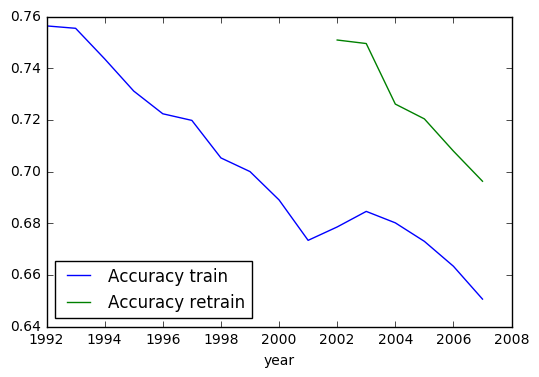

In [54]:
# Airline Retrain Results
plot_metrics(accuracy_dict, accuracy_retrain, label1='Accuracy train', label2='Accuracy retrain', x_label='year')

As it can be seen, the performance is better after retraining. We have found concept drift in this dataset.